In [22]:
import time

import jax
import jax.numpy as jnp
from jax.experimental import pallas as pl
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-v0_8-whitegrid')

In [14]:
def sum_kernel(x_ref, o_ref):
    """Read-only: sum all elements (heavy read, minimal write)."""
    s = jnp.sum(x_ref[...])
    o_ref[...] = jnp.broadcast_to(s, x_ref[...].shape)


def copy_kernel(x_ref, o_ref):
    """Copy: read and write (both directions)."""
    o_ref[...] = x_ref[...]


def make_sum(size: int, dtype=jnp.bfloat16):
    return pl.pallas_call(
        sum_kernel,
        out_shape=jax.ShapeDtypeStruct((size,), dtype),
    )


def make_fill(size: int, dtype=jnp.bfloat16):
    """Write-only: fill with constant (no read, heavy write)."""
    def fill_kernel(o_ref):
        o_ref[...] = jnp.ones((size,), dtype=dtype)

    return pl.pallas_call(
        fill_kernel,
        out_shape=jax.ShapeDtypeStruct((size,), dtype),
    )


def make_copy(size: int, dtype=jnp.bfloat16):
    return pl.pallas_call(
        copy_kernel,
        out_shape=jax.ShapeDtypeStruct((size,), dtype),
    )

In [15]:
def benchmark(fn, *args, warmup=3, runs=20):
    """Time a function, return stats."""
    # Warmup
    for _ in range(warmup):
        result = fn(*args)
        if hasattr(result, 'block_until_ready'):
            result.block_until_ready()

    # Timed runs
    times = []
    for _ in range(runs):
        start = time.perf_counter()
        result = fn(*args)
        if hasattr(result, 'block_until_ready'):
            result.block_until_ready()
        times.append(time.perf_counter() - start)

    return {
        'mean': np.mean(times),
        'std': np.std(times),
        'min': np.min(times),
        'max': np.max(times),
        'times': times,
    }

In [16]:
size = 512
dtype = jnp.bfloat16
x = jnp.ones((size,), dtype)

sum_fn = make_sum(size, dtype)
fill_fn = make_fill(size, dtype)
copy_fn = make_copy(size, dtype)

print(f"fill result shape: {fill_fn().shape}")
print(f"copy result shape: {copy_fn(x).shape}")

fill result shape: (512,)
copy result shape: (512,)


In [17]:
compiled = sum_fn.lower(x).compile({'xla_enable_transpose_trace': True})
result = compiled(x)

result.block_until_ready()
with jax.profiler.trace('./traces'):
    result = compiled(x)
    result.block_until_ready()

In [ ]:
dtype = jnp.bfloat16
itemsize = jnp.dtype(dtype).itemsize

sizes_bytes = [1024 * (2 ** i) for i in range(15)]  # 1KB to 16MB
sizes_elems = [s // itemsize for s in sizes_bytes]

results = {'sum': [], 'fill': [], 'copy': []}

for size_bytes, size_elems in zip(sizes_bytes, sizes_elems):
    x = jnp.ones((size_elems,), dtype)
    
    sum_fn = make_sum(size_elems, dtype)
    # This OOMs
    stats = benchmark(sum_fn, x, warmup=2, runs=10)
    results['sum'].append({'size_bytes': size_bytes, **stats})
    
    fill_fn = make_fill(size_elems, dtype)
    stats = benchmark(fill_fn, warmup=2, runs=10)
    results['fill'].append({'size_bytes': size_bytes, **stats})
    
    copy_fn = make_copy(size_elems, dtype)
    stats = benchmark(copy_fn, x, warmup=2, runs=10)
    results['copy'].append({'size_bytes': size_bytes, **stats})
    
    print(f"{size_bytes/1024:>8.0f} KB done")

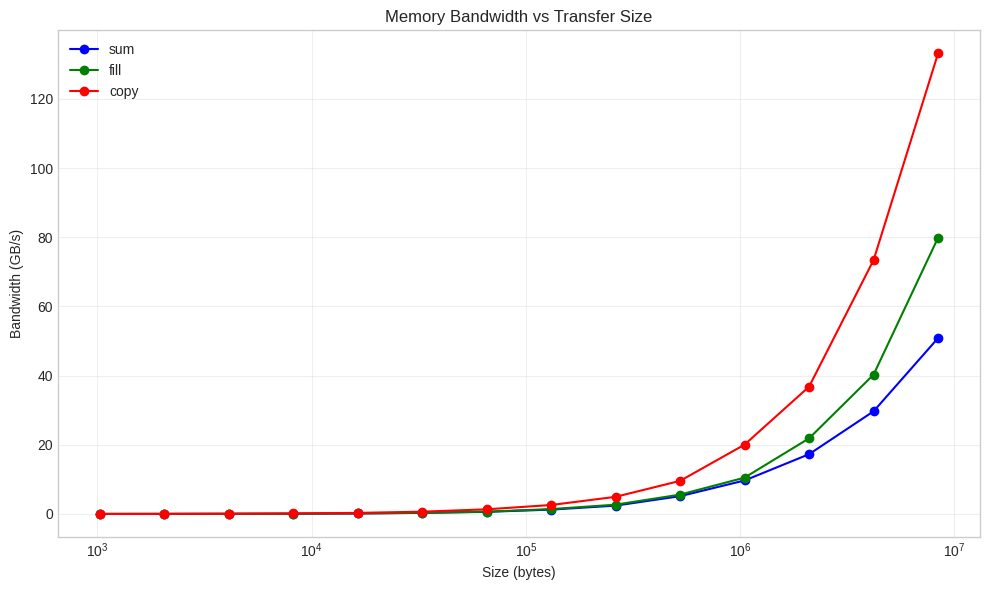

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))

for name, color in [('sum', 'blue'), ('fill', 'green'), ('copy', 'red')]:
    sizes = [r['size_bytes'] for r in results[name]]
    times = [r['mean'] for r in results[name]]
    
    # Bandwidth = bytes / time
    # For sum: read size_bytes
    # For fill: write size_bytes  
    # For copy: read + write = 2 * size_bytes
    if name == 'copy':
        bandwidths = [2 * s / t / 1e9 for s, t in zip(sizes, times)]  # GB/s
    else:
        bandwidths = [s / t / 1e9 for s, t in zip(sizes, times)]  # GB/s
    
    ax.plot(sizes, bandwidths, 'o-', label=name, color=color)

ax.set_xscale('log')
ax.set_xlabel('Size (bytes)')
ax.set_ylabel('Bandwidth (GB/s)')
ax.set_title('Memory Bandwidth vs Transfer Size')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
print("Peak bandwidths (GB/s):")
for name in ['sum', 'fill', 'copy']:
    sizes = [r['size_bytes'] for r in results[name]]
    times = [r['mean'] for r in results[name]]
    if name == 'copy':
        bandwidths = [2 * s / t / 1e9 for s, t in zip(sizes, times)]
    else:
        bandwidths = [s / t / 1e9 for s, t in zip(sizes, times)]
    print(f"  {name}: {max(bandwidths):.2f} GB/s")